In [1]:
import qetpy as qp
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from rqpy import io
import rqpy as rp
import pandas as pd
from glob import glob

Specify which series we will be creating a PSD from (assuming we have beginning-of-run randoms).

In [12]:
series = '09210830_180510' # data series to pull randoms from for making the template

# set the path to the raw files to process
basepath = '/gpfs/slac/staas/fs1/g/supercdms/data/CDMS/SLAC/R85/Raw/'

# set the detector labels and corresponding channels
labels = {"iZIP"}
channels = ["PAS1","PBS1","PCS1","PDS1","PES1","PFS1","PAS2","PBS2","PCS2","PDS2","PES2","PFS2"]
det = ['Z2','Z2','Z2','Z2','Z2','Z2','Z2','Z2','Z2','Z2','Z2','Z2']

fs = 625e3

In [18]:
#filelist = sorted(glob(f"{basepath}{series}/*"))[:10] # first 10 dumps should have about 5000 randoms
filelist = sorted(glob(f"{basepath}{series}/*"))[:5]
print(f"There are {len(filelist)} files.")

There are 5 files.


Print QET bias in order to check that things make sense.

In [13]:
for ch, d in zip(channels, det):
    #print(ch, io.get_trace_gain(f"{basepath}{series}/", ch, d)[-1]*1e6)
    print(ch, io.get_trace_gain(f"{basepath}{series}/", ch, d)[-1]*1e6)

PAS1 187.014404296875
PBS1 197.96319580078125
PCS1 203.98899841308594
PDS1 211.99819946289062
PES1 204.04049682617188
PFS1 189.022705078125
PAS2 174.985107421875
PBS2 184.98060607910153
PCS2 173.960205078125
PDS2 192.03179931640625
PES2 177.00599670410156
PFS2 190.0301055908203


Open the raw data to get beginning of run randoms. Specify `convtoamps` as 1 to keep units in terms of ADC bins.

In [19]:
events, info_dict = io.get_traces_midgz(filelist, channels, det, convtoamps=1, lgcreturndict=True)
print((info_dict['triggertype'][0]))

2


`tlen` specifies if we want to truncate the traces. We truncate to 16384 bins, as this is the length that the L1 Trigger requires.

In [26]:
tlen = 16384
nbin = events.shape[-1]
if tlen > nbin:
    tlen = nbin
print(f"tlen = {tlen} -> ~{tlen/fs*1e3:.2f} ms traces, truncated from nbin = {nbin} -> ~{nbin/fs*1e3:.2f} ms traces.")

tlen = 16384 -> ~26.21 ms traces, truncated from nbin = 32768 -> ~52.43 ms traces.


Extract the beginning-of-run randoms from the loaded traces.

In [27]:
cevent = []
for d in set(det):
    cevent.append(np.array(info_dict[f'readoutstatus{d}'])==1)

cevent = np.logical_and.reduce(cevent)
cpsd = cevent & (np.array(info_dict['triggertype'])==2)

x = events[cpsd, ..., nbin//2 - tlen//2:nbin//2 + tlen//2 + tlen%2]
print(f"There are {cpsd.sum()} randoms loaded.")

There are 589 randoms loaded.


Make PSDs using `qetpy.autocuts`.

In [32]:
template_dict = {}
for ii, (chan, d) in enumerate(zip(channels, det)):
#for ii in enumerate(label):
    
    print(f"Calculating PSD for channel {chan}, detector {d}")
    cut = qp.autocuts(x[:, ii], fs=fs)
    f, psd = qp.calc_psd(x[cut, ii], fs=fs, folded_over=False)
    f_fold, psd_fold = qp.foldpsd(psd, fs)
    #if ii==3:
    #    psd_fold[(f_fold<2e4)&(f_fold>6e3)]=1.5
    #    psd[(f<2e4)&(f>6e3)]=1.5
    template_dict[f"f_{chan}{d}"] = f
    template_dict[f"psd_{chan}{d}"] = psd
    template_dict[f"f_fold_{chan}{d}"] = f_fold
    template_dict[f"psd_fold_{chan}{d}"] = psd_fold
    print(f"The passage fraction for {chan}{d} is {cut.sum()/cpsd.sum():.3f}")    

Calculating PSD for channel PAS1, detector Z2
The passage fraction for PAS1Z2 is 0.290
Calculating PSD for channel PBS1, detector Z2
The passage fraction for PBS1Z2 is 0.246
Calculating PSD for channel PCS1, detector Z2
The passage fraction for PCS1Z2 is 0.217
Calculating PSD for channel PDS1, detector Z2
The passage fraction for PDS1Z2 is 0.275
Calculating PSD for channel PES1, detector Z2
The passage fraction for PES1Z2 is 0.236
Calculating PSD for channel PFS1, detector Z2
The passage fraction for PFS1Z2 is 0.399
Calculating PSD for channel PAS2, detector Z2
The passage fraction for PAS2Z2 is 0.166
Calculating PSD for channel PBS2, detector Z2
The passage fraction for PBS2Z2 is 0.214
Calculating PSD for channel PCS2, detector Z2
The passage fraction for PCS2Z2 is 0.304
Calculating PSD for channel PDS2, detector Z2
The passage fraction for PDS2Z2 is 0.355
Calculating PSD for channel PES2, detector Z2
The passage fraction for PES2Z2 is 0.202
Calculating PSD for channel PFS2, detector 

Plot the PSDs that were calculated using `qetpy.autocuts`.

<>:13: DeprecationWarning: invalid escape sequence \s
<>:13: DeprecationWarning: invalid escape sequence \s
<>:13: DeprecationWarning: invalid escape sequence \s
<ipython-input-33-628aeca9f067>:13: DeprecationWarning: invalid escape sequence \s
  ax.set_ylabel("Current PSD [ADC bins/$\sqrt{\mathrm{Hz}}$]", fontsize=14)


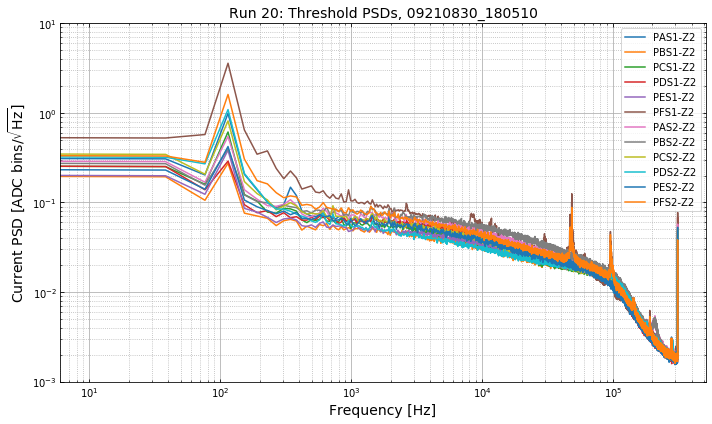

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

for ii, (chan, d) in enumerate(zip(channels, det)):
    ax.loglog(template_dict[f'f_fold_{chan}{d}'], template_dict[f'psd_fold_{chan}{d}']**0.5, 
              label=f"{chan}-{d}")
ax.legend()
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.grid(which="minor", linestyle="dotted")
ax.grid(which="major")
ax.set_title(f"Run 20: Threshold PSDs, {series}", fontsize=14)
ax.set_ylim(1e-3, 1e1);
ax.set_xlabel("Frequency [Hz]", fontsize=14)
ax.set_ylabel("Current PSD [ADC bins/$\sqrt{\mathrm{Hz}}$]", fontsize=14)
ax.set_xlim(6, 5.1e5)
fig.tight_layout()


In this notebook, we use `rqpy.make_ideal_template` to create the expected pulse shapes for each channel.

The PD2 pulse shape was determined from the theoretical TES rise and fall times. (PD2 has a phonon collection time of 20 us and an effective TES fall time of 80 us.)

In [40]:
risetimes = 20e-6*np.ones(12) #[20e-6]  rise times for each channel in s
falltimes = 55e-6*np.ones(12) #[95e-6]  fall times for each channel in s
#40  risetime
#600 falltime
temp=[0,0]

#with open('CPDtemp_11-03-2021.npy', 'rb') as f:
#
#    temp[0] = np.load(f)
#with open('CPDtemp_11-03-2021.npy', 'rb') as f:
#
#    temp[1] = np.load(f)
    
for ii, (ch, d) in enumerate(zip(channels, det)):
    template_dict[f'template_{ch}{d}'] =rp.make_ideal_template(
       np.arange(events.shape[-1])/fs,
       risetimes[ii],
       falltimes[ii],
        )[nbin//2 - tlen//2:nbin//2 + tlen//2 + tlen%2]
    
    #if ii==1:
    #    template_dict[f'template_{ch}{d}'] = temp[0][::2]/max(temp[ii])
    
    
    
    
    #rp.make_ideal_template(
     #   np.arange(events.shape[-1])/fs,
      #  risetimes[ii],
       # falltimes[ii],
    #)[nbin//2 - tlen//2:nbin//2 + tlen//2 + tlen%2]

In [41]:
ii=0
print(len(rp.make_ideal_template(
        np.arange(events.shape[-1])/fs,
        risetimes[ii],
        falltimes[ii],
    )[nbin//2 - tlen//2:nbin//2 + tlen//2 + tlen%2]))

16384


Plot the template.

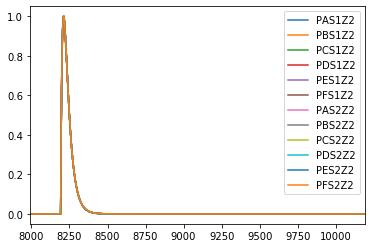

In [42]:
for ch, d in zip(channels, det):
    plt.plot(template_dict[f'template_{ch}{d}'], label=f"{ch}{d}")
plt.xlim(tlen//2 - 200, tlen//2 + 2000)
plt.legend();

Save the dictionary to a specified path.

In [43]:
pathtotemplate = 'SLAC_iZIP'

filename = f"{pathtotemplate}template_{series}"

nversions = len(glob(f"{filename}*"))+1

if nversions>0:
    filename = filename + f"_v{nversions}"
print(filename)

SLAC_iZIPtemplate_09210830_180510_v1


Uncomment and run the below cell to actually save the file.

In [44]:
with open(f"{filename}.pkl", 'wb') as f:
     pkl.dump(template_dict, f)